<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h2><center>Seminar: Neural Networks 1</center></h2>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

## Почему *обратное* распространение?

### Обозначения и затравочка

Рассмотрим такой пример нейронной сети.

<center><img src='img/nn.png'></center>

* $x_i$ - входной слой. Сюда подаются признаки объектов. $i$ - это индексы признаков объекта
* $z_j$, $z_k$ - скрытые слои.
* $z_m$ - выходной слой. Тут выводятся результаты вычислений сети. $j$, $k$, $m$ - индексы нейронов в этих слоях
* $w_{\cdot,\cdot}$ - веса, связывающие нейроны соседних слоев

Дополнительно введем следующие обозначения:
* $net^{(1)}_j = net_j = \sum_iw_{ij}x_i$ 
* $net^{(2)}_k = net_k =  \sum_jw_{jk}z_j$ 
* $net^{(3)}_m = net_m \sum_kw_{km}z_k$

*Верхние индексы мы пока опустим, но в части про векторизацию к ним вернемся*


Так же:
* $z_j = f^{(h)}(net_j)$ 
* $z_k = f^{(k)}(net_k)$
* $z_m = f^{(r)}(net_m)$

где $f(\cdot)$ - некоторая функция активации.

Нам так же понадобится функция потерь $L(W)$, которая зависит от весов $w_{\cdot, \cdot}$.

Если бы мы хотели обучаться с помощью простого градиентного спуска, то нам нужно было на каждом шаге расчитывать
частные производные по всем весам: 

$\frac{\partial L}{\partial w_{ij}}$, $\frac{\partial L}{\partial w_{jk}}$, $\frac{\partial L}{\partial w_{km}}$

Достаточно выписать вычисления нейронной сети в виде формулы, чтобы понять, что "такой футбол нам не нужен" и хоть и вычислять эти производные можно, это займет много времени. Есть ли способ как-то ускорить расчет производных?

### Идея метода

Поступим следующим образом - случайно инициализируем начальные веса и пропустим один объект $(x(t), y(t))$ по нейронной сети с прямом направлении (forward pass). Получим ответ нейронной сети на одном из выходов $z_m = \hat{y}(t)$.

Посчитаем $\frac{\partial L}{\partial w_{km}}$, воспользовавшись правилами дифференцирования сложных функций:

$$
\begin{align*} 
\frac{\partial L}{\partial w_{km}} &=  \underline{\frac{\partial L}{\partial z_m} \cdot \frac{\partial z_m}{\partial net_m}} \cdot \frac{\partial net_m}{\partial w_{km}} \\ 
 &= \underline{\frac{\partial L}{\partial z_m} \cdot f^{(3)`}(net_m)} \cdot z_k
\end{align*}
$$
*Первые два члена выделены неслучайно!*

Okey, пока ничего особенного. Переходим на слой назад:
$$
\begin{align} 
\frac{\partial L}{\partial w_{jk}} &=  (\frac{\partial L}{\partial z_k}) & \cdot & \frac{\partial z_k}{\partial net_k} & \cdot & \frac{\partial net_k}{\partial w_{jk}} \\ 
 &= \left(\sum_m\underline{\frac{\partial L}{\partial z_m} \cdot \frac{\partial z_m}{\partial net_m}} \cdot \frac{\partial net_m}{\partial z_k}\right) & \cdot & f^{(2)`}(net_k) & \cdot & z_j \\
 &= \left(\sum_m\underline{\frac{\partial L}{\partial z_m} \cdot f^{(3)`}(net_m)} \cdot w_{km}\right) & \cdot & f^{(2)`}(net_k) & \cdot & z_j \\
\end{align}
$$
*Надеюсь форматирование вас не запутало*

Что же мы видим? Некоторую часть выражения для $\frac{\partial L}{\partial w_{jk}}$ мы уже считали на слое выше! Причем эта часть отвечает именно за производную ошибки по выходу сети! Более того, эта часть входит с весом $ w_{km}$, который как раз связывает эти слои. Таким образом, можно сказать, что ошибка начинает *распростроняться в обратном направлении* по слоям, пропоционально весам между слоями. 

Отсюда и название метода.

Eсли мы продолжим вывод для весов $w_{ij}$, то так же заметим там часть, ранее посчитанную на этапе с весами $w_{jk}$



### Обобщение

Становится ясно, что можно как-то записать вычисление в "рекурсивном" виде между слоями.

Пусть один объект прошел по сети с результатом $\hat{y}(t)$.

Рассмотрим выражение для нейрона $l$
$$ \delta_l = \frac{\partial L}{\partial net_l} = \frac{\partial L}{\partial \hat{y}(t)} \cdot \frac{\partial \hat{y}(t)}{\partial net_l}$$
и назовем это **сигнал об ошибке**, проходящий через нейрон $l$.

Если нейрон $l$ находится на выходном слое, то просто считаем $\frac{\partial L}{\partial \hat{y}(t)}$, а $\frac{\partial \hat{y}(t)}{\partial net_l} = \frac{\partial z_l}{\partial net_l} = f^{`}(net_l)$

Eсли нейрон $l$ находится в промежуточном слое, то $\frac{\partial \hat{y}(t)}{\partial net_l}$ надо расписать через нейроны следующего (в направлении выхода сети) слоя:

$$
\begin{align} 
\frac{\partial \hat{y}(t)}{\partial net_l} &= \frac{\partial \hat{y}(t)}{\partial z_l} & \cdot \frac{\partial z_l}{\partial net_l} \\ 
&= \sum_{o \in out(l)} \left(\frac{\partial \hat{y}(t)}{\partial net_o} \cdot \frac{\partial net_o}{\partial z_l} \right) & \cdot f^{`}(net_l) \\
&= \sum_{o \in out(l)} \left(\frac{\partial \hat{y}(t)}{\partial net_o} \cdot w_{lo} \right) & \cdot f^{`}(net_l) 
\end{align}
$$ 

Теперь доставим это выражение в "определение" $\delta_l$:
$$
\begin{align} 
\delta_l &=  \frac{\partial L}{\partial \hat{y}(t)} \cdot \frac{\partial \hat{y}(t)}{\partial net_l} \\ 
&= \frac{\partial L}{\partial \hat{y}(t)} \cdot \sum_{o \in out(l)} \left(\frac{\partial \hat{y}(t)}{\partial net_o} \cdot w_{lo} \right) \cdot f^{`}(net_l) \\
&=  \sum_{o \in out(l)} \left(\frac{\partial L}{\partial \hat{y}(t)} \cdot \frac{\partial \hat{y}(t)}{\partial net_o} \cdot w_{lo} \right) \cdot f^{`}(net_l) \\
&=  \sum_{o \in out(l)} \left(\delta_o \cdot w_{lo} \right) \cdot f^{`}(net_l) \\
\end{align}
$$ 

Красота!



### В итоге - шаги алгоритма backpropagation

Ниже преставленны шаги алгоритма обратного распространения ошибки с проходом одним случайным объектом. Проход всеми объектами выборки или батчем получается из данной записи очевидным образом.

1. Некоторым образом инициализируем все веса сети
2. Прогоняем случайный объект $x(t)$ по сети, попутно запоминая все $net_l$ и $z_l$ для всех слоев
3. Считаем $\delta_l$: если слой  $l$ выходной, то 
$$ \delta_l = f^{(l)`}(net_l) \frac{\partial L}{\partial \hat{y}(t)} $$
иначе 
$$ \delta_l = f^{(l)`}(net_l) \sum_{o \in out(l)} \delta_o w_{lo}$$
4. Обновляем веса по следующему правилу
$$ w_{jk} = w_{jk} - \alpha \cdot \delta_k \cdot z_j $$
5. Если правило останова не выполнено, перейти к шагу 2

## Векторизация

### Прямой проход

Понятно, что операции, которые проходят в нейронной сети можно векторизовать.

Например, умножение на веса и переход к следующему слою можно просто расписать в виде умножения на матрицу:

$$\left\{net^{(1)}_j\right\}^{J}_{j=1} = \left\{ \sum_iw_{ij}x_i \right\}^{J}_{j=1} = W^{i \rightarrow j}x = net^{(1)} $$

Eсли же мы хотим применить какую-то функцию активации $f(\cdot)$, то смело поэлементно применяем ее к $net^{(1)}$

$$ Z^{(1)} = f(net^{(1)}) $$

<center><img src='img/vect.png'></center>

Таким образом, все что происходит в полносвязной сети можно реализовать с помощью матричных операций.
Например, сеть с двумя слоями с сигмойдными функциями активации записывается как

$$y = \sigma(W_2\sigma(W_1x)) $$

### Обратный проход

Запишем сигнал об ошибке
$$ \left\{\delta_l\right\}^{L}_{l=1} = \left\{ f^{(l)`}(net_l) \sum_{o \in out(l)} \delta_o w_{lo} \right\}^{L}_{l=1}$$
в векторизованном виде:

$$
\Delta^{(1)} = f^{`}(net^{(1)}) \odot \Delta^{(2)} W^{(1 \rightarrow 2)}
$$
а для выходново слоя
$$
\Delta^{(out)} = f^{`}(net^{(out)}) \odot \frac{\partial L}{\partial \hat{y}}
$$


Тогда веса следует обновлять так:

$$ W^{(1 \rightarrow 2)} = W^{(1 \rightarrow 2)} - \alpha Z^{{(1)}^\top} \Delta^{(2)} $$

И так для всех слоев

<center><img src='img/back.png'></center>

## Практика

Основано на материале из [cs231n](http://cs231n.github.io/neural-networks-case-study/).

Возьмем какой-нибудь простой датасет для классификации и обучим на нем нейронную сеть с одним скрытым слоем с функцией активации ReLU. <br\>
На выходе, расчеты должны пройти через SoftMax.
$$z_l = \frac{\exp(net_l)}{\sum_l \exp(net_l)} \text{ - это softmax}$$
Таким образом, нейронная сеть должна для каждого класса возвращать вероятность принадлежности ему объекта, который через нее прошел.

Ошибка в нашем случае будет выражаться как кросс-энтропия. Величину ошибки на одном объекте вычиляем так
$$L(\hat{y}(t)) = - \sum\limits_{c \in classes} y_c\log(\hat{y}_c)$$
Общая ошибка с регуляризацией:
$$L = \frac{1}{N}\sum\limits_{t=1}^N L(\hat{y}(t)) + \lambda\frac{1}{2}\|\mathbf{W}\|^2$$

In [3]:
from sklearn.datasets import make_moons

In [4]:
N = 100 # кол-во объектов
D = 2 # кол-во признаков
K = 2 # кол-во классов
X, y = make_moons(n_samples=N, noise=0.1, random_state=123)
C = 0.01 # гиперпараметр регуляризации

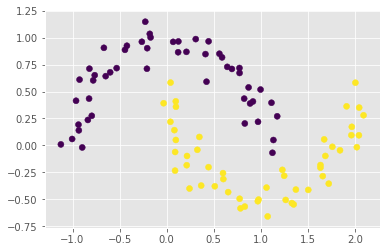

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y)

Удобно сделать one-hot encoding для кодирования истинной метки классов объектов

In [7]:
y_bool = np.zeros((N, K))
y_bool[range(N), y] += 1

Задаем колиество нейронов в первом слое и веса

In [10]:
D

2

In [12]:
K

2

In [13]:
h = 50 
# Матрица весов между 
# входным слоем и промежуточным скрытым
W = 0.01 * np.random.randn(D,h) 
b = np.zeros((1,h)) # св член

# Матрица между промежуточным
# скрытым слоем и выходным слоем
W2 = 0.01 * np.random.randn(h,K) 
b2 = np.zeros((1,K)) # св член

In [15]:
W.shape

(2, 50)

In [14]:
W2.shape

(50, 2)

### Прямой проход

In [21]:
X.dot(W).dot(W2).shape

(100, 2)

In [22]:
# Прогоняем всю выборку через сеть
hidden_layer = np.maximum(0, np.dot(X, W) + b) 
scores = np.dot(hidden_layer, W2) + b2 # "Сырой" выход сети
probs = np.exp(scores)/np.exp(scores).sum(axis=1, keepdims=True)

In [24]:
errors = -(y_bool * np.log(probs))

In [26]:
total_error = errors.sum()
print(total_error)

69.3233240174608


Обратите внимание, что на каждом сле у нас есть свободный член b и b2. У них тоже есть веса и их надо учитывать

## Обратный проход

Начинаем с того, что с считаем $\Delta^{(out)}$ на выходном слое.

Оказывется, что в случае с softmax и кросс-энтропией $\Delta^{(out)}$ будет выражаться очень просто!

$$ \Delta^{(out)} = \hat{y} - y $$

In [27]:
dscores = probs - y_bool

In [28]:
dscores.shape

(100, 2)

Таким образом градиент на веса между выходным и скрытым слоем выражается как 

$$\Delta W_2 = Z^{{(1)}^\top}\Delta^{(out)}$$

In [30]:
# производные по весам
# между выходным и конечным слоем
dW2 = np.dot(hidden_layer.T, dscores) + C*W2 # Не забываем регуляризацию

# производная по весам для свободного члена
db2 = np.sum(dscores, axis=0, keepdims=True)


Идем дальше

$$\Delta^{(1)} = f^{`}(net^{(1)}) \odot D^{(2)} W^{(1 \rightarrow 2)}$$

In [31]:
## Это просто пошагово
# dhidden_rpart = np.dot(dscores, W2.T) # Правая часть выражения
# dhidden_lpart = (hidden_layer >= 0).astype(int) # Производная ReLU
# dhidden = dhidden_lpart * dhidden_rpart # Результат

dhidden = np.dot(dscores, W2.T)
dhidden[hidden_layer <= 0] = 0

Таким образом градитент по весам

In [32]:
dW = np.dot(X.T, dhidden) + C*W
db = np.sum(dhidden, axis=0, keepdims=True)

Вот и все, дальше нужно итеративно обновлять веса

In [42]:
# Your Code Here
alpha = 0.01
max_iters = 10000

h = 50 
# Матрица весов между 
# входным слоем и промежуточным скрытым
W = 0.01 * np.random.randn(D,h) 
b = np.zeros((1,h)) # св член

# Матрица между промежуточным
# скрытым слоем и выходным слоем
W2 = 0.01 * np.random.randn(h,K) 
b2 = np.zeros((1,K)) # св член

for i in range(max_iters):
    
    # Прямой проход
    # Прогоняем всю выборку через сеть
    hidden_layer = np.maximum(0, np.dot(X, W) + b) 
    scores = np.dot(hidden_layer, W2) + b2 # "Сырой" выход сети
    probs = np.exp(scores)/np.exp(scores).sum(axis=1, keepdims=True)
    
    errors = -(y_bool * np.log(probs))
    total_error = errors.mean()
    if (i % 100) == 0:
        print(total_error)

    
    # Обратный проход
    dscores = probs - y_bool
    
    # между выходным и конечным слоем
    dW2 = np.dot(hidden_layer.T, dscores) + C*W2 # Не забываем регуляризацию

    # производная по весам для свободного члена
    db2 = np.sum(dscores, axis=0, keepdims=True)
    
    dhidden = np.dot(dscores, W2.T)
    dhidden[hidden_layer <= 0] = 0
    
    dW = np.dot(X.T, dhidden) + C*W
    db = np.sum(dhidden, axis=0, keepdims=True)

    
    # Обновление весов
    W = W - alpha * dW
    b = b - alpha * db
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2

0.34670890694957424
0.13316569112579202
0.13313604749766544
0.1176771746418301
0.11370756188679565
0.11233204557582853
0.11171876084165587
0.11146677567860701
0.1111198325255528
0.11099875856691523
0.11086846430935253
0.11075978363731448
0.11070672967237029
0.11064599677000399
0.11059059075174744
0.11061472982219593
0.11054077584964148
0.11047769858382966
0.11051328248820605
0.11048784442368717
0.11043912876099675
0.11045507770135478
0.11045076916170406
0.11036405111636492
0.11034452535712096
0.11031924769150883
0.11030099692304451
0.110283119184428
0.11021615106348934
0.11018892160399671
0.11020872172639748
0.11018030780568931
0.11016620412457749
0.11015712746505514
0.11016803798136524
0.1101217214074568
0.11014610708954824
0.11016670220188195
0.11012491438715782
0.11011388201133354
0.1100864529305519
0.11010636586637494
0.11012676766890647
0.11007548318900633
0.11009779677786621
0.11007304339979751
0.11009627271257613
0.11009064068241928
0.11008798821329792
0.11009386156401142
0.1100

In [46]:
(np.argmax(probs, axis=1) == y).mean()

0.89

# NN in Keras

In [48]:
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

RND_SEED = 7
plt.style.use('ggplot')

np.random.seed(RND_SEED)

%matplotlib inline

## Классификация

### Загрузка данных

Для тренеровки мы будем использовать достаточно известный набор данных [Pima Indians](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data).

Признаки такие: <br\>
1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)
9. Class variable (0 or 1)


In [49]:
df = pd.read_csv('data/diabetes.csv',
                 sep=',')

In [50]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [51]:
X, y = df.iloc[:, :8].values, df.iloc[:, 8].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=RND_SEED)

## Составляем модель

Построим простую 2х (3х) слойную нейронную сеть. Делать это в keras одно удовольствие

In [52]:
X.shape

(768, 8)

In [53]:
model = Sequential()
model.add(Dense(12, input_dim=8, init='normal', activation='sigmoid'))
model.add(Dense(8, init='normal', activation='sigmoid'))
model.add(Dense(1, init='uniform', activation='sigmoid'))

Теперь надо задать функцию [ошибки](https://keras.io/objectives/), способ [оптимизации](https://keras.io/optimizers/) и метрику измерения [качества](https://keras.io/metrics/):

In [54]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], )

## Обучаем

In [55]:
X_train.shape

(614, 8)

In [56]:
# Fit the model
model.fit(X_train, y_train, nb_epoch=150, batch_size=10, validation_split=0.2)

Train on 491 samples, validate on 123 samples
Epoch 1/150
491/491 [==============================] - 0s - loss: 0.6844 - acc: 0.6273 - val_loss: 0.6733 - val_acc: 0.6504
Epoch 2/150
491/491 [==============================] - 0s - loss: 0.6629 - acc: 0.6578 - val_loss: 0.6584 - val_acc: 0.6504
Epoch 3/150
491/491 [==============================] - 0s - loss: 0.6527 - acc: 0.6578 - val_loss: 0.6508 - val_acc: 0.6504
Epoch 4/150
491/491 [==============================] - 0s - loss: 0.6467 - acc: 0.6578 - val_loss: 0.6487 - val_acc: 0.6504
Epoch 5/150
491/491 [==============================] - 0s - loss: 0.6442 - acc: 0.6578 - val_loss: 0.6475 - val_acc: 0.6504
Epoch 6/150
491/491 [==============================] - 0s - loss: 0.6425 - acc: 0.6578 - val_loss: 0.6465 - val_acc: 0.6504
Epoch 7/150
491/491 [==============================] - 0s - loss: 0.6418 - acc: 0.6578 - val_loss: 0.6459 - val_acc: 0.6504
Epoch 8/150
491/491 [==============================] - 0s - loss: 0.6413 - acc: 0.6578

491/491 [==============================] - 0s - loss: 0.5682 - acc: 0.6578 - val_loss: 0.5779 - val_acc: 0.6504
Epoch 67/150
491/491 [==============================] - 0s - loss: 0.5674 - acc: 0.6578 - val_loss: 0.5716 - val_acc: 0.6504
Epoch 68/150
491/491 [==============================] - 0s - loss: 0.5723 - acc: 0.6578 - val_loss: 0.5745 - val_acc: 0.6504
Epoch 69/150
491/491 [==============================] - 0s - loss: 0.5740 - acc: 0.6578 - val_loss: 0.5832 - val_acc: 0.6504
Epoch 70/150
491/491 [==============================] - 0s - loss: 0.5691 - acc: 0.6578 - val_loss: 0.5797 - val_acc: 0.6504
Epoch 71/150
491/491 [==============================] - 0s - loss: 0.5664 - acc: 0.6578 - val_loss: 0.5738 - val_acc: 0.6585
Epoch 72/150
491/491 [==============================] - 0s - loss: 0.5653 - acc: 0.6619 - val_loss: 0.5806 - val_acc: 0.6504
Epoch 73/150
491/491 [==============================] - 0s - loss: 0.5655 - acc: 0.6741 - val_loss: 0.5753 - val_acc: 0.6585
Epoch 74/150


491/491 [==============================] - 0s - loss: 0.5416 - acc: 0.7352 - val_loss: 0.5865 - val_acc: 0.6748
Epoch 132/150
491/491 [==============================] - 0s - loss: 0.5361 - acc: 0.7108 - val_loss: 0.5939 - val_acc: 0.6667
Epoch 133/150
491/491 [==============================] - 0s - loss: 0.5420 - acc: 0.7169 - val_loss: 0.6056 - val_acc: 0.6667
Epoch 134/150
491/491 [==============================] - 0s - loss: 0.5364 - acc: 0.7088 - val_loss: 0.5991 - val_acc: 0.6667
Epoch 135/150
491/491 [==============================] - 0s - loss: 0.5365 - acc: 0.7108 - val_loss: 0.5952 - val_acc: 0.6585
Epoch 136/150
491/491 [==============================] - 0s - loss: 0.5393 - acc: 0.7088 - val_loss: 0.5858 - val_acc: 0.6829
Epoch 137/150
491/491 [==============================] - 0s - loss: 0.5368 - acc: 0.7230 - val_loss: 0.6052 - val_acc: 0.6829
Epoch 138/150
491/491 [==============================] - 0s - loss: 0.5361 - acc: 0.7067 - val_loss: 0.6041 - val_acc: 0.6423
Epoch 

## Оценка качества

In [59]:
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

128/154 [=======================>......] - ETA: 0s
acc: 75.32%


In [60]:
y_hat = model.predict(X_test).flatten()

In [62]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline

In [63]:
def gen_model():
    model = Sequential()
    model.add(Dense(12, input_dim=8, init='normal', activation='sigmoid'))
    model.add(Dense(8, init='normal', activation='sigmoid'))
    model.add(Dense(1, init='uniform', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], )
    
    return model

In [69]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', KerasClassifier(build_fn=gen_model, nb_epoch=150, batch_size=10))
])

In [70]:
model.fit(X_train, y=y_train, )

Epoch 1/150
614/614 [==============================] - 0s - loss: 0.6782 - acc: 0.6498     
Epoch 2/150
614/614 [==============================] - 0s - loss: 0.6558 - acc: 0.6564     
Epoch 3/150
614/614 [==============================] - 0s - loss: 0.6442 - acc: 0.6564     
Epoch 4/150
614/614 [==============================] - 0s - loss: 0.6373 - acc: 0.6564     
Epoch 5/150
614/614 [==============================] - 0s - loss: 0.6328 - acc: 0.6564     
Epoch 6/150
614/614 [==============================] - 0s - loss: 0.6300 - acc: 0.6564     
Epoch 7/150
614/614 [==============================] - 0s - loss: 0.6263 - acc: 0.6564     
Epoch 8/150
614/614 [==============================] - 0s - loss: 0.6236 - acc: 0.6564     
Epoch 9/150
614/614 [==============================] - 0s - loss: 0.6213 - acc: 0.6564     
Epoch 10/150
614/614 [==============================] - 0s - loss: 0.6180 - acc: 0.6564     
Epoch 11/150
614/614 [==============================] - 0s - loss: 0.6152 - acc

614/614 [==============================] - 0s - loss: 0.4831 - acc: 0.7557     
Epoch 90/150
614/614 [==============================] - 0s - loss: 0.4832 - acc: 0.7557     
Epoch 91/150
614/614 [==============================] - 0s - loss: 0.4827 - acc: 0.7541     
Epoch 92/150
614/614 [==============================] - 0s - loss: 0.4826 - acc: 0.7557     
Epoch 93/150
614/614 [==============================] - 0s - loss: 0.4828 - acc: 0.7557     
Epoch 94/150
614/614 [==============================] - 0s - loss: 0.4825 - acc: 0.7524     
Epoch 95/150
614/614 [==============================] - 0s - loss: 0.4822 - acc: 0.7573     
Epoch 96/150
614/614 [==============================] - 0s - loss: 0.4820 - acc: 0.7590     
Epoch 97/150
614/614 [==============================] - 0s - loss: 0.4823 - acc: 0.7573     
Epoch 98/150
614/614 [==============================] - 0s - loss: 0.4818 - acc: 0.7541     
Epoch 99/150
614/614 [==============================] - 0s - loss: 0.4822 - acc: 0.

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('nn', <keras.wrappers.scikit_learn.KerasClassifier object at 0x1a1da81850>)])

In [79]:
y_hat = model.predict(X_test).flatten()

140/154 [==========================>...] - ETA: 0s

In [80]:
(y_test == y_hat).mean()

0.7857142857142857

# Регрессия

Будем строить регрессию на данных [Boston Housing Data Set](https://archive.ics.uci.edu/ml/datasets/Housing)

Описание:<br\>
1. CRIM: per capita crime rate by town
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS: proportion of non-retail business acres per town
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX: nitric oxides concentration (parts per 10 million)
6. RM: average number of rooms per dwelling
7. AGE: proportion of owner-occupied units built prior to 1940
8. DIS: weighted distances to five Boston employment centres
9. RAD: index of accessibility to radial highways
10. TAX: full-value property-tax rate per 10,000 USD
11. PTRATIO: pupil-teacher ratio by town
12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT: lower status of the population
14. MEDV: Median value of owner-occupied homes in 1000's USD

Весь pipeline практически повторяется. Ну и повторим.

In [ ]:
from sklearn import datasets

In [ ]:
boston = datasets.load_boston()